# Tabnet

Grupo 5



Las redes neuronales profundas son muy potentes para clasificar imágenes, texto y audio. Pero estas redes neuronales basadas en perceptrones convolucionales o multicapa apilados, pueden no ser las más adecuadas para las variedades de decisión de datos tabulares debido a que están muy sobre parametrizadas. A pesar que los datos tabulares son el tipo de datos más común, la exploración en arquitecturas de redes neuronales para la comprensión de este tipo de datos ha sido muy poca, por lo que los métodos basados en árboles de decisión son los más utilizados en este campo. Una de las razones de la popularidad de los enfoques basados en árboles es su poder de representación para múltiples decisiones regulares con límites de aproximadamente hiperplano que se observan comúnmente para datos tabulares, además son fáciles de desarrollar, rápidos de entrenar y son altamente interpretables en su forma básica. Pero las redes neuronales profundas en datos tabulares ofrecen un alto rendimiento, debido al uso del descenso del gradiente, a diferencia del aprendizaje de árbol de decisión no utiliza el back propagation y el error no puede guiar el aprendizaje.

TabNet emplea múltiples bloques de decisión que se enfocan en procesar un subconjunto de características de entrada para la toma de decisiones en general. Dos bloques de decisión que se muestran como ejemplos procesan las características que están relacionadas con la ocupación profesional y con la inversión para predecir el nivel de ingresos.

El diseño de TabNet tiene 2 objetivos que a menudo no se consideran en conjunto: rendimiento e interpretabilidad. Tabnet es el primer modelo de aprendizaje de datos tabulares con una arquitectura de red neuronal profunda de extremo a extremo que asigna los datos sin procesar a la decisión final y , al mismo tiempo, permite la selección de características de instancia para la interpretación. Tabnet ingresa datos tabulares sin realizar ningún preprocesamiento de características (excepto el mapeo a incrustaciones entrenables y normalización de lotes) y se entrena mediante aprendizaje de extremo a extremo basado en el descenso de gradientes.
Tabnet utiliza un mecanismo de atención secuencial para elegir las características a partir de las cuales razonar en cada paso de decisión. Esta selección de características en función de la instancia de modo que el modelo pueda decidir en qué características enfocarse en función de la entrada. Esta selección explícita de características dispersas permite la interpretación, así como un aprendizaje más eficiente, ya que los parámetros del modelo se utilizan completamente para las características más destacadas en el paso de decisión correspondiente.
Este mecanismo de selección secuencia permite lograr lo siguiente:
1 TabNet supera a otros modelos de aprendizaje de datos tabulares publicados en varios conjuntos de datos para problemas de clasificación y regresión de diferentes dominios y 
2 TabNet permite 2 tipos de interpretabilidad: interpretabilidad local que visualiza la importancia de las características de entrada y cómo se combinan, e interpretabilidad global que cuantifica la cantidad de contribución de cada característica de entrada al modelo entrenado.

## a) Descripción del problema

Predecir si los ingresos superan los $ 50K / año según los datos del censo. También conocido como conjunto de datos "Ingresos del censo".
La tarea de predicción es determinar si una persona gana más de 50 mil al año.

In [ ]:
!pip install pytorch_tabnet

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=aa60e66df6615297f5b17f550573882553c7d3b25cfcf2e7b1ed6a15a9d80e49
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,f1_score,precision_recall_curve

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          label = "label",
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Correct '+label)
        plt.xlabel('Predicted ' +label+ stats_text)
    else:
        plt.xlabel(stats_text)
    

    if title:
        plt.title(title)
    else:
        plt.title("Consusion matrix")

## Descarga de dataset censo ingresos

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [ ]:
out.parent.mkdir(parents=True,exist_ok=True)
if out.exists():
  print("Archivo ya existe")
else:
  print("Descargando archivo...")
  wget.download(url,out.as_posix())
  

Descargando archivo...


In [ ]:
train =pd.read_csv(out, header=None)

## b) Analisis y presentacion del dataset de entrenamiento

In [ ]:
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Listing of attributes:

- 0 age: continuous.
- 1 workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- 2 fnlwgt: continuous.
- 3 education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- 4 education-num: continuous.
- 5 marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- 6 occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- 7 relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- 8 race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- 9 sex: Female, Male.
- 10 capital-gain: continuous.
- 11 capital-loss: continuous.
- 12 hours-per-week: continuous.
- 13 native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
- 14 target: >50K, <=50K.

In [ ]:
print(train.shape[0])
print(len(train))

32561
32561


Definiremos el index de la columna target y agregamos columna adicional llamada Set para dividir la data en train (80%), valid(10%) y test (10%

In [ ]:
target =14
if "Set" not in train.columns:
  train["Set"] = np.random.choice(['train','valid','test'], p = [.8,.1,.1],size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index



In [ ]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Set
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,train
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,valid
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,train
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,train
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,train


## Preprocesado simple
Etiquetado codificado de columnas categoricas y completamos las celdas vacías con el promedio.
Para este caso se considerará columnas categóricas cuando el tipo de la columna sea object o el número de valores unicos sea menor a 200



In [ ]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims = {}
for col in train.columns:
  if types[col] == 'object' or nunique[col] < 200:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)
  else:
    train.fillna(train.loc[train_indices, col].mean(), inplace = True)


0 73
1 9
3 16
4 16
5 7
6 15
7 6
8 5
9 2
10 119
11 92
12 94
13 42
14 2
Set 3


## Se definen las columnas categóricas y el número de etiquetas por cada una de ellas

In [ ]:
unused_feat = ['Set']

features = [col for col in train.columns if col not in unused_feat+[target]]
cat_idxs  = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
print(f"Used features: {features}")
print("-------")
print(f"Categorical features indices: {cat_idxs}")
print("-------")
print(f"Number of modalities per categorical feature: {cat_dims}")


Used features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
-------
Categorical features indices: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
-------
Number of modalities per categorical feature: [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]


## c) Análisis y presentación de la arquitectura

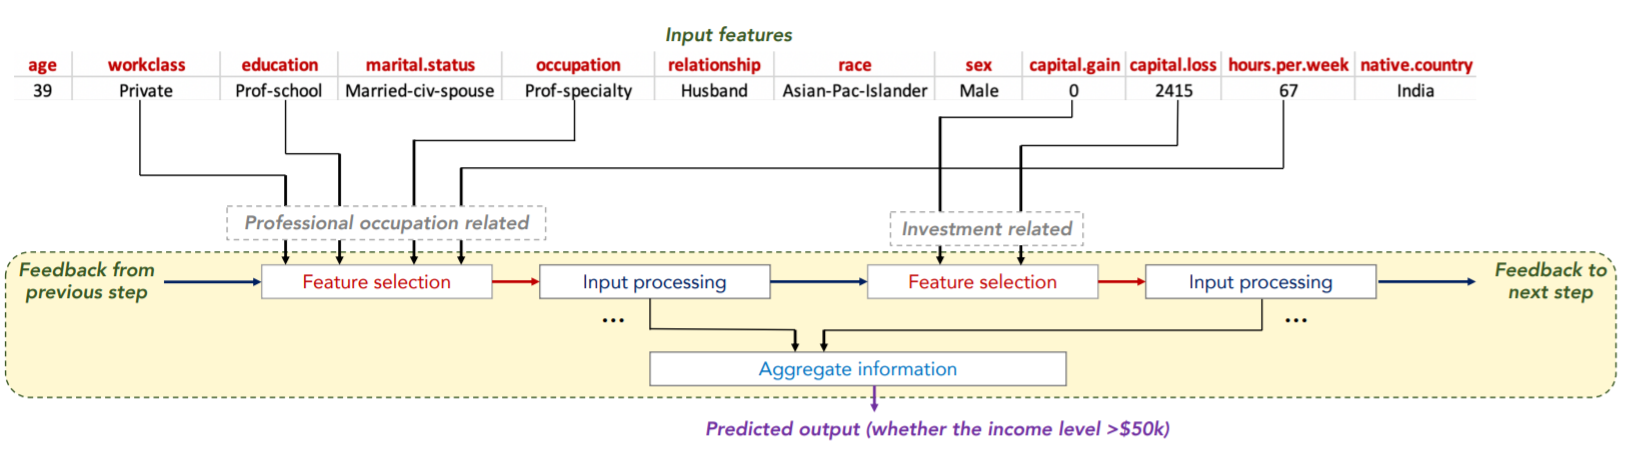

TabNet emplea múltiples bloques de decisión que se enfocan en procesar un subconjunto de características de entrada para la toma de decisiones en general. Dos bloques de decisión que se muestran como ejemplos procesan las características que están relacionadas con la ocupación profesional y con la inversión para predecir el nivel de ingresos.



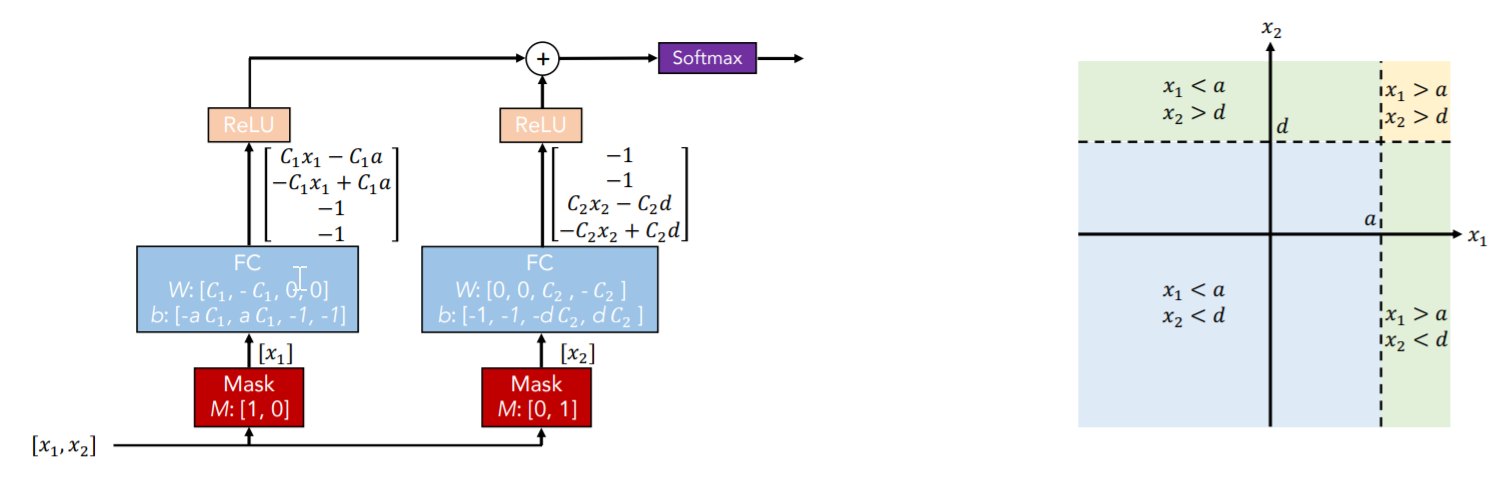

Ilustración de una clasificación similar a un árbol de decisiones utilizando bloques de redes neuronales convencionales y la correspondiente variedad bidimensional (
X1 y X2 son las dimensiones de entrada, y a y d son constantes). Empleando máscaras dispersas multiplicativas en las entradas, se seleccionan las características relevantes. Las características seleccionadas se transforman linealmente y después de una adición de sesgo (bias para representar los límites), la función ReLU realiza la selección de la región poniendo a cero las regiones que están en el lado negativo del límite. La agregación de varias regiones se basa en la operación de adición. Como
C1 y C2 se hace más grande, el límite de decisión se vuelve más nítido debido al softmax.

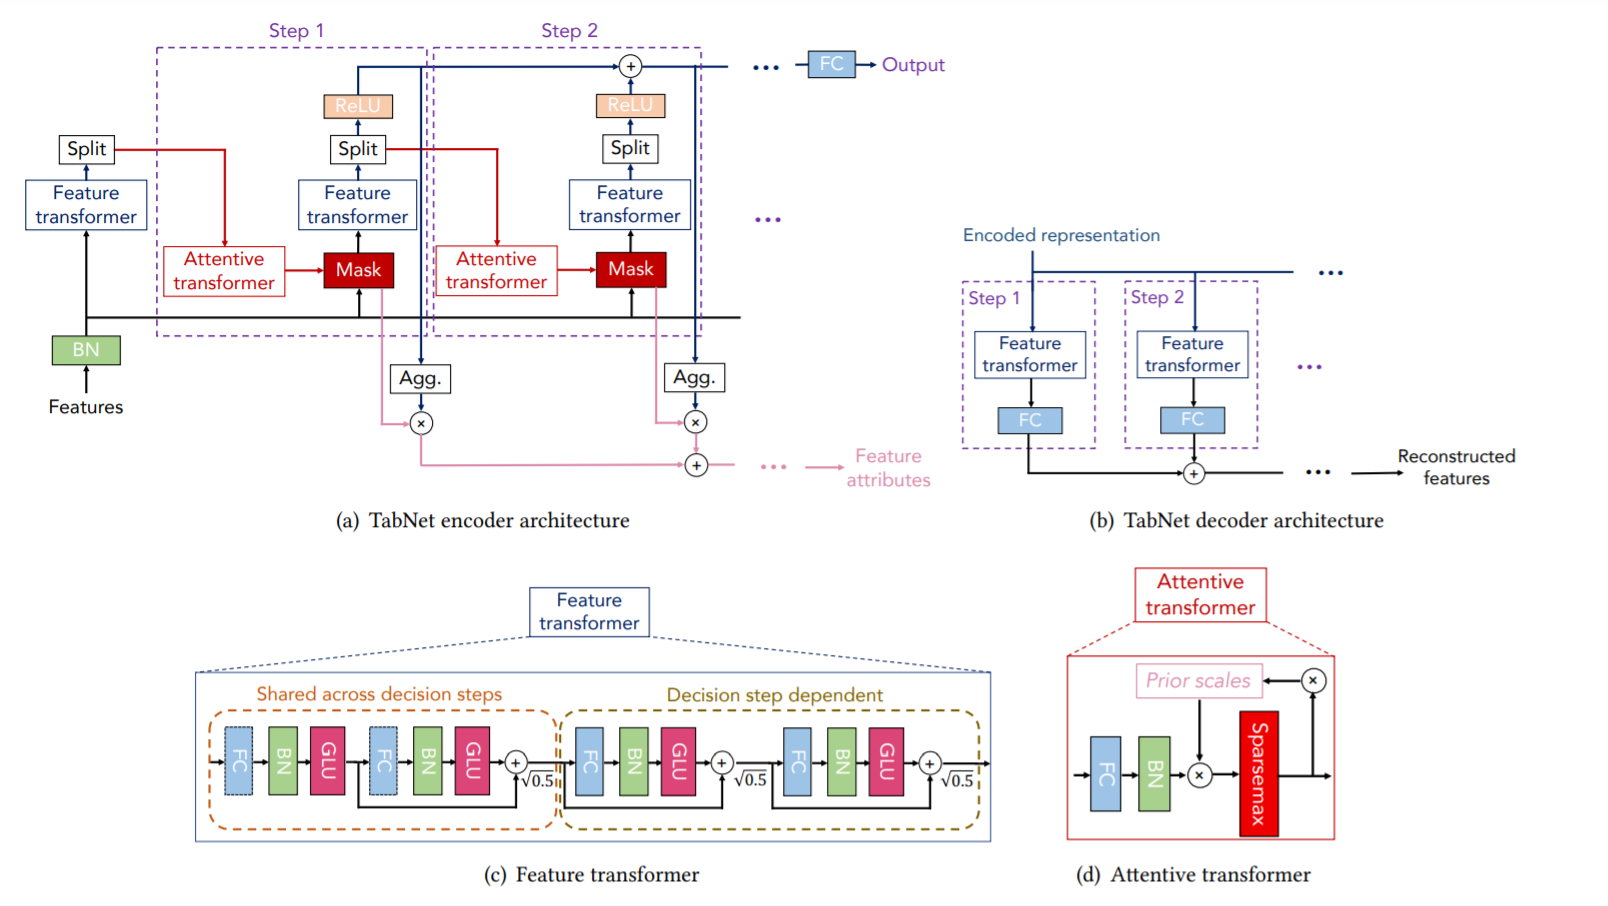

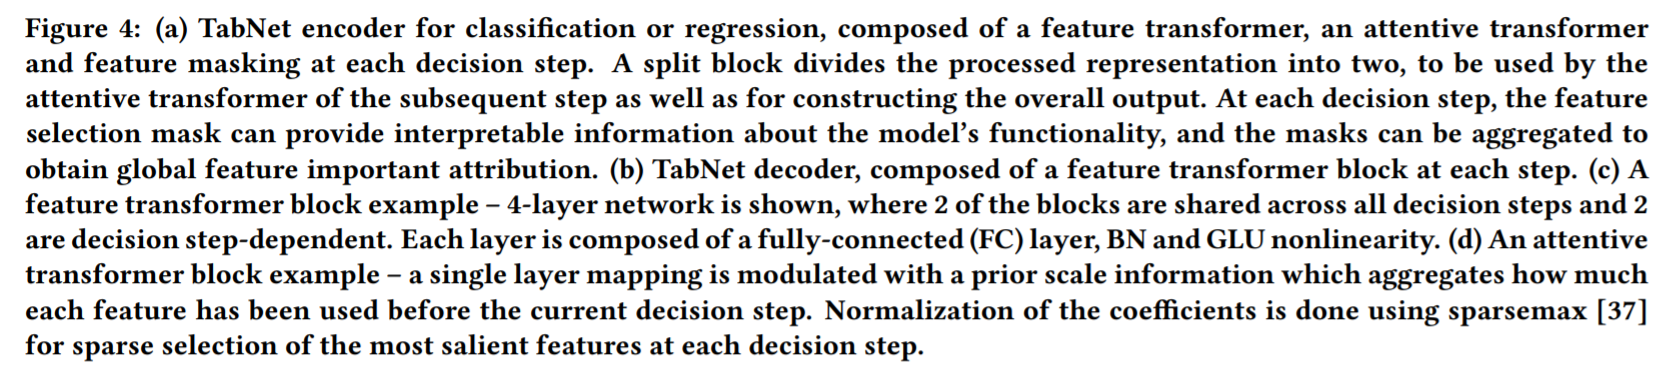

## Casos de uso

- Tipo de cobertura forestal : este conjunto de datos corresponde a la tarea de clasificación del tipo de cobertura forestal a partir de variables cartográficas.
- Sarcos Robotics Arm Inverse Dynamics: El conjunto de datos corresponde a la tarea de regresión de dinámica inversa de siete grados de libertad de un brazo robótico antropomórfico.
- HIGGS Data Set Este es un problema de clasificación para distinguir entre un proceso de señal que produce bosones de Higgs y un proceso de fondo que no lo hace.
- Rossmann Store Sales: este conjunto de datos corresponde a la tarea de pronosticar las ventas en la tienda a partir de características estáticas y variables en el tiempo.
- Todos los que sean problemas con datos tabulares.

## Demostración del código funcional

In [ ]:
clf = TabNetClassifier(cat_idxs=cat_idxs,cat_dims=cat_dims, cat_emb_dim=1)

Device used : cpu


In [ ]:
clf

TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], cat_dims=[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='auto')

## Entrenamiento

In [ ]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [ ]:
X_train.shape

(26072, 14)

In [ ]:
max_epochs = 1000 if not os.getenv("CI", False) else 20

In [ ]:
clf.fit(
    X_train = X_train, y_train = y_train,
    #X_valid = X_valid, y_valid = y_valid,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs = max_epochs, patience = 20,
    batch_size =1024, virtual_batch_size = 128,
    num_workers=0,
    weights=1,
    drop_last = False
)


epoch 0  | loss: 0.69099 | train_auc: 0.68619 | valid_auc: 0.67896 |  0:00:04s
epoch 1  | loss: 0.55448 | train_auc: 0.78055 | valid_auc: 0.76958 |  0:00:07s
epoch 2  | loss: 0.50845 | train_auc: 0.80962 | valid_auc: 0.80184 |  0:00:11s
epoch 3  | loss: 0.47211 | train_auc: 0.84749 | valid_auc: 0.84145 |  0:00:15s
epoch 4  | loss: 0.44308 | train_auc: 0.86865 | valid_auc: 0.85896 |  0:00:19s
epoch 5  | loss: 0.41815 | train_auc: 0.89014 | valid_auc: 0.88347 |  0:00:23s
epoch 6  | loss: 0.40919 | train_auc: 0.89544 | valid_auc: 0.89419 |  0:00:27s
epoch 7  | loss: 0.3896  | train_auc: 0.89664 | valid_auc: 0.89369 |  0:00:31s
epoch 8  | loss: 0.38885 | train_auc: 0.90463 | valid_auc: 0.89562 |  0:00:35s
epoch 9  | loss: 0.38228 | train_auc: 0.90966 | valid_auc: 0.89942 |  0:00:39s
epoch 10 | loss: 0.37528 | train_auc: 0.91069 | valid_auc: 0.90356 |  0:00:42s
epoch 11 | loss: 0.36439 | train_auc: 0.91951 | valid_auc: 0.91245 |  0:00:46s
epoch 12 | loss: 0.35812 | train_auc: 0.91938 | vali

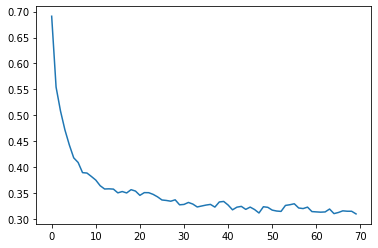

In [ ]:
#plot losses
plt.plot(clf.history['loss'])


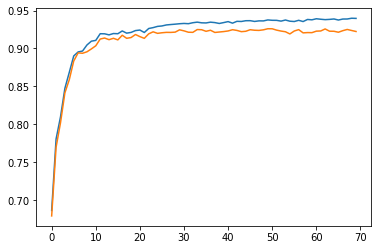

In [ ]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

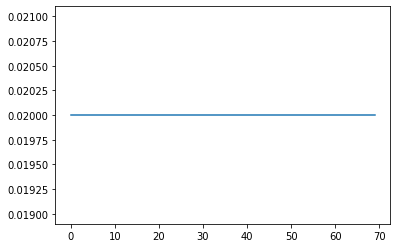

In [ ]:
plt.plot(clf.history['lr'])


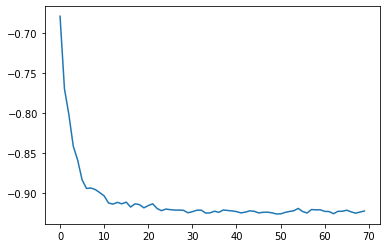

In [ ]:
plt.plot([-x for x in clf.history['valid_auc']])

## Predicciones

In [ ]:
preds_test = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds_test[:,1], y_true = y_test)
print (f"Mejor Score de validación {dataset_name} : {clf.best_cost}")
print(f"Mejor score para test {dataset_name} : {test_auc}")

Mejor Score de validación census-income : 0.9260662569567167
Mejor score para test census-income : 0.9230495604937858


In [ ]:
preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

In [ ]:
preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)


print(f"FINAL VALID SCORE FOR {dataset_name} : {clf.history['valid_auc'][-1]}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

FINAL VALID SCORE FOR census-income : 0.9224295096668689
FINAL TEST SCORE FOR census-income : 0.9230495604937858


In [ ]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

### Matriz de confusión

In [ ]:
pd.value_counts(y_test)

0    2504
1     764
dtype: int64

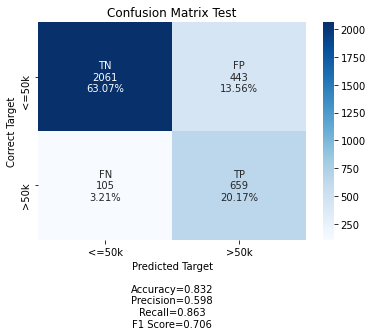

In [ ]:
from sklearn.metrics import confusion_matrix

umbral = 0.5
y_pred_valid =  preds_valid[:,1]> umbral
y_pred_test =  preds_test[:,1]> umbral
cf_matrix_valid = confusion_matrix(y_true=y_valid,y_pred=y_pred_valid)
cf_matrix_test = confusion_matrix(y_true=y_test,y_pred=y_pred_test)

labels = ['TN','FP','FN','TP']
categories = ['<=50k', '>50k']
make_confusion_matrix(cf_matrix_test, 
                      group_names=labels,
                      label = "Target",
                      categories=categories, 
                      cmap='Blues',
                      title = "Confusion Matrix Test")

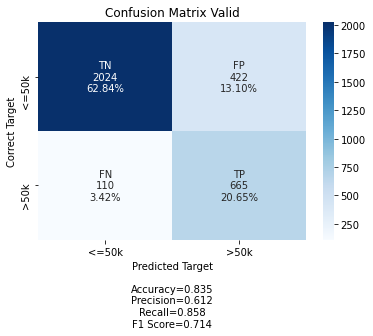

In [ ]:
make_confusion_matrix(cf_matrix_valid, 
                      group_names=labels,
                      label = "Target",
                      categories=categories, 
                      cmap='Blues',
                      title = "Confusion Matrix Valid")

## Global explainability : feat importance summing to 1


In [ ]:
clf.feature_importances_


array([8.25934292e-07, 5.51662837e-03, 5.57048280e-06, 4.63345709e-02,
       6.93009133e-02, 3.71589501e-02, 8.69701331e-02, 9.43271936e-04,
       1.48984688e-02, 4.78720888e-02, 3.55298775e-01, 1.87655817e-01,
       1.44062160e-01, 3.98182622e-03])

## Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

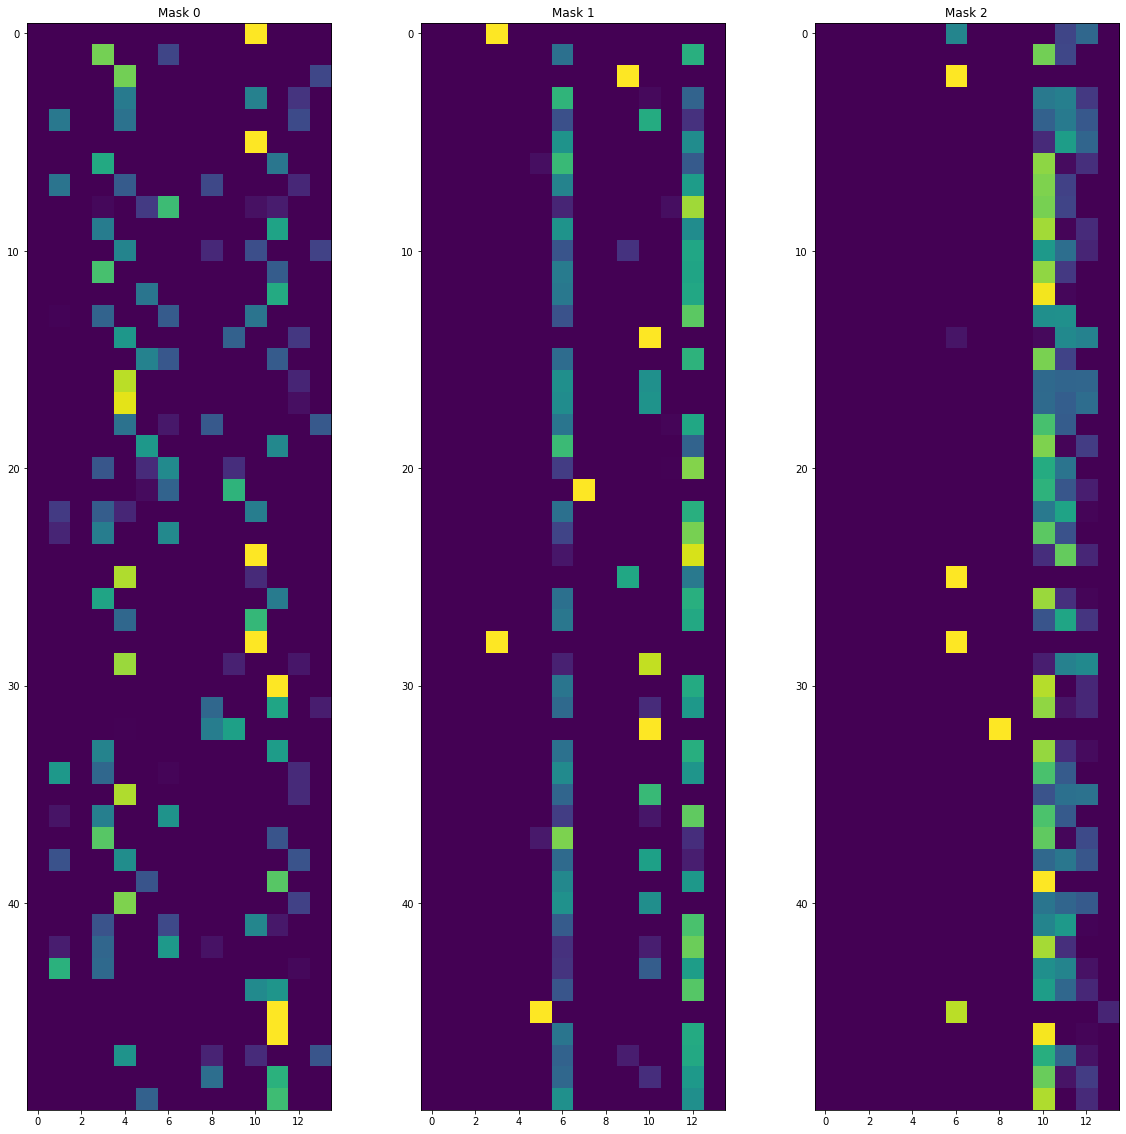

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(20,20))

for i in range (3):
  axs[i].imshow(masks[i][:50])
  axs[i].set_title(f"Mask {i}")

In [ ]:
clf.save_model("/content/data/model_income")

Successfully saved model at /content/data/model_income.zip


'/content/data/model_income.zip'

XGB

In [ ]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-error:0.149022
Will train until validation_0-error hasn't improved in 40 rounds.
[10]	validation_0-error:0.140019
[20]	validation_0-error:0.136293
[30]	validation_0-error:0.130084
[40]	validation_0-error:0.125737
[50]	validation_0-error:0.127911
[60]	validation_0-error:0.125737
[70]	validation_0-error:0.125737
[80]	validation_0-error:0.124495
[90]	validation_0-error:0.126669
[100]	validation_0-error:0.125116
[110]	validation_0-error:0.125737
Stopping. Best iteration:
[75]	validation_0-error:0.123875



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=0)

In [ ]:
xgb_preds_valid = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=xgb_preds_valid[:,1], y_true=y_valid)
print(valid_auc)

xgb_preds_test = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=xgb_preds_test[:,1], y_true=y_test)
print(test_auc)

0.9250797879355366
0.9206285649766657


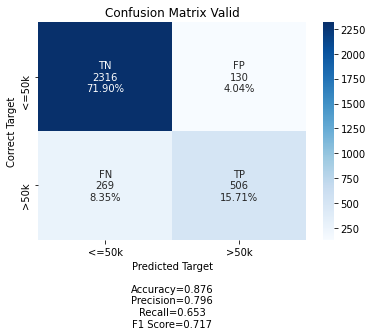

In [ ]:
umbral_xgb = 0.5
y_pred_valid_xgb =  xgb_preds_valid[:,1]> umbral_xgb
y_pred_test_xgb =  xgb_preds_test[:,1]> umbral_xgb
cf_matrix_xgb_valid = confusion_matrix(y_true=y_valid,y_pred=y_pred_valid_xgb)
cf_matrix_xgb_test = confusion_matrix(y_true=y_test,y_pred=y_pred_test_xgb)

labels = ['TN','FP','FN','TP']
categories = ['<=50k', '>50k']
make_confusion_matrix(cf_matrix_xgb_valid, 
                      group_names=labels,
                      label = "Target",
                      categories=categories, 
                      cmap='Blues',
                      title = "Confusion Matrix Valid")

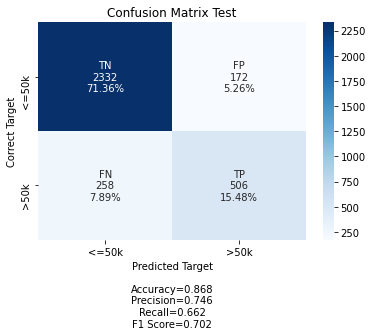

In [ ]:
make_confusion_matrix(cf_matrix_xgb_test, 
                      group_names=labels,
                      label = "Target",
                      categories=categories, 
                      cmap='Blues',
                      title = "Confusion Matrix Test")